<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' EDA and Pre-processing

This notebook contains EDA (Exploratory Data Analysis) for COVID-19 related tweets organized according ot the following steps:

1. Context and datset info    
2. Imports and loading data
3. Covid situation worldwide
4. Basic EDA and text prep
    - Lowercase
    - Punctuations  
    - Tokenization
    - Stopwords
    - Stemming and Lemmatization
    - Word Clouds
    - Bigrams and Trigrams
    - Text Networks
    - Emojis
5. Saving the output file

### 1. Context and datset info

Dataset consists of 426,426 tweets exctacted using Tweepy (with developer access, tweets up to 7 days old) and snscraper (tweets older than 7 days) libraries with Twitter API.  

Applied filters:
- timeframes: 2020-03-01 - 2021-04-30 (maximum 1000 tweets per day)  
- query keywords: covid, coronavirus, corona, pandemic, vaccine, vaccinated, lockdown, quarantine 
- retweets and replies excluded
- only English language included 

### 2. Imports and loading data


In [311]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
# import prettyplotlib as plt
import plotly.express as px

import nltk
from nltk import bigrams, ngrams, everygrams 
import emojis
import itertools
import collections
import networkx as nx

import string
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

import emoji
sns.set_theme()
pd.set_option('mode.chained_assignment', None)
plt.style.use('seaborn-dark-palette')

In [378]:
tweets_df = pd.read_csv('../data/covid19_tweets_snscrape_daily.csv')
covid_df = pd.read_csv('../data/owid-covid-data.csv')

#### Data leballing...

In [313]:
tweets_dfdf = tweets_df.sample(n=5000, random_state=42)
tweets_df = tweets_df.reset_index(drop=True)
# tweets_df.to_excel('../data/covid19_to_label_5000.xlsx', index=False)

In [314]:
tweets_df = pd.read_excel('../data/covid19_label_5000.xlsx')

In [315]:
tweets_df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment     location_new  
0            43  negative         Nieznana  
1           935   neutral              USA  
2          1828   neutral        Australia  
3         14712  positive  Wielka Brytania  
4          1231  positive         Nieznana

In [316]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   text          5000 non-null   object
 2   datetime      5000 non-null   object
 3   no_replies    5000 non-null   int64 
 4   no_retweets   5000 non-null   int64 
 5   no_likes      5000 non-null   int64 
 6   user          5000 non-null   object
 7   location      3767 non-null   object
 8   no_followers  5000 non-null   int64 
 9   sentiment     5000 non-null   object
 10  location_new  5000 non-null   object
dtypes: int64(5), object(6)
memory usage: 429.8+ KB


In [317]:
tweets_df.iloc[0,1]

'covid still exists and yall are so so close to mark 😤😤😤😤😤😤😤'

In [318]:
tweets_df.iloc[1,1]

'School districts plan for the most UNFEASABLE safe PLAN ON OVERCROWDED busing amid COVID-19 pandemic @briantylercohen \n\nhttps://t.co/EncYxekkiM via @YouTube'

In [319]:
tweets_df.iloc[2,1]

'COVID-19 Omnibus (Emergency Measures) Bill 2020 introduced and released (but not on the parliamentary website) #springst'

### 3. Covid situation worldwide


In [320]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98432 entries, 0 to 98431
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               98432 non-null  object 
 1   continent                              93808 non-null  object 
 2   location                               98432 non-null  object 
 3   date                                   98432 non-null  object 
 4   total_cases                            94976 non-null  float64
 5   new_cases                              94973 non-null  float64
 6   new_cases_smoothed                     93963 non-null  float64
 7   total_deaths                           84879 non-null  float64
 8   new_deaths                             85035 non-null  float64
 9   new_deaths_smoothed                    93963 non-null  float64
 10  total_cases_per_million                94470 non-null  float64
 11  ne

In [379]:
covid_df = covid_df.loc[(covid_df['date'] >= '2020-03-01') & (covid_df['date'] <= '2021-04-30')]
covid_df['date'] = pd.to_datetime(covid_df['date'])

location_list = ['United States', 'Canada', 'United Kingdom', 'Australia', 'India']
covid_df = covid_df.loc[covid_df['location'].isin(location_list)]
covid_df.head()

iso_code continent   location       date  total_cases  new_cases  \
5188      AUS   Oceania  Australia 2020-03-01         27.0        2.0   
5189      AUS   Oceania  Australia 2020-03-02         30.0        3.0   
5190      AUS   Oceania  Australia 2020-03-03         39.0        9.0   
5191      AUS   Oceania  Australia 2020-03-04         52.0       13.0   
5192      AUS   Oceania  Australia 2020-03-05         55.0        3.0   

      new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
5188               1.714           1.0         1.0                0.143  ...   
5189               2.143           1.0         0.0                0.143  ...   
5190               3.429           1.0         0.0                0.143  ...   
5191               5.286           2.0         1.0                0.286  ...   
5192               5.714           2.0         0.0                0.286  ...   

      extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
5188              0.5                107.791                 5.07   
5189              0.5                107.791                 5.07   
5190              0.5                107.791                 5.07   
5191              0.5                107.791                 5.07   
5192              0.5                107.791                 5.07   

      female_smokers  male_smokers  handwashing_facilities  \
5188            13.0          16.5                     NaN   
5189            13.0          16.5                     NaN   
5190            13.0          16.5                     NaN   
5191            13.0          16.5                     NaN   
5192            13.0          16.5                     NaN   

      hospital_beds_per_thousand  life_expectancy  human_development_index  \
5188                        3.84            83.44                    0.944   
5189                        3.84            83.44                    0.944   
5190                        3.84            83.44                    0.944   
5191                        3.84            83.44                    0.944   
5192                        3.84            83.44                    0.944   

      excess_mortality  
5188              7.69  
5189               NaN  
5190               NaN  
5191               NaN  
5192               NaN  

[5 rows x 60 columns]

In [374]:
# Changing to polish naming convention

In [382]:
covid_df["location"].replace({"United States": "USA", "Canada": "Kanada", "United Kingdom": "Wielka Brytania", "India": "Indie"}, inplace=True)
covid_df['location'].value_counts()

Wielka Brytania    426
Indie              426
USA                426
Australia          426
Kanada             426
Name: location, dtype: int64

<AxesSubplot:xlabel='date', ylabel='new_vaccinations'>

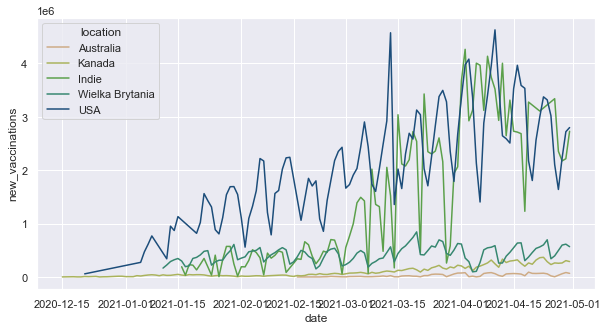

In [394]:
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='new_vaccinations', hue='location', data=covid_df, palette='gist_earth_r')

<ipython-input-413-d76e7c5cfc62>:25: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:27: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:29: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:31: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:38: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



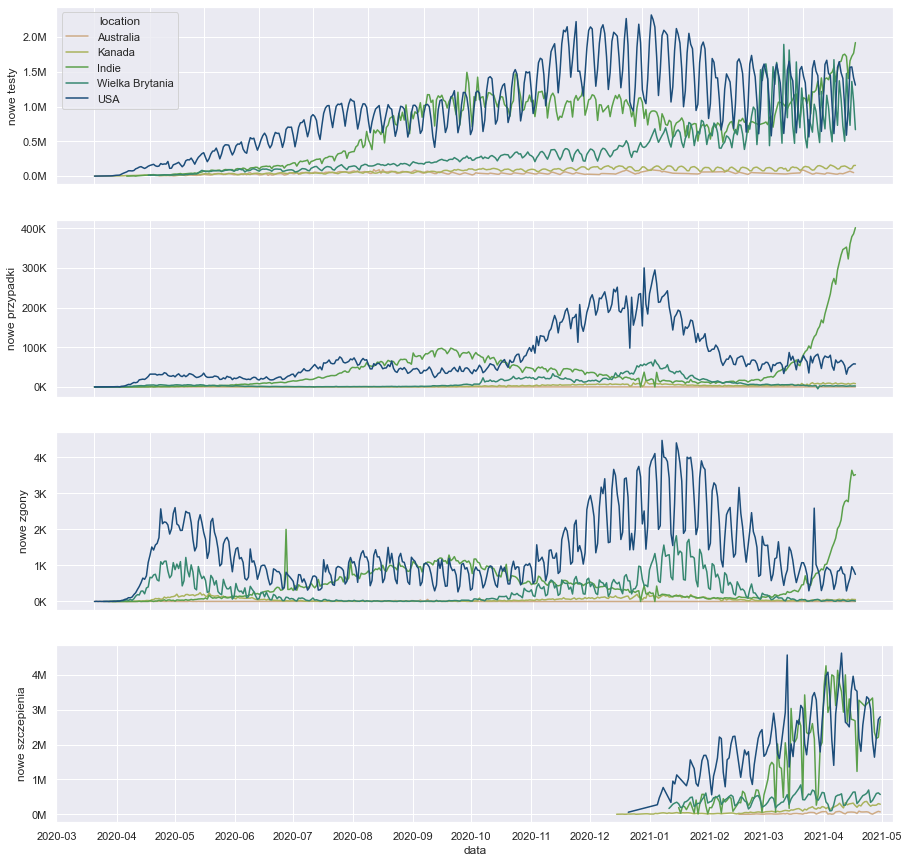

In [413]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 15))
sns.lineplot(x='date', y='new_tests', hue='location', data=covid_df, ax=ax1, palette='gist_earth_r')
sns.lineplot(x='date', y='new_cases', hue='location', data=covid_df, ax=ax2, palette='gist_earth_r')
sns.lineplot(x='date', y='new_deaths', hue='location', data=covid_df, ax=ax3, palette='gist_earth_r')
sns.lineplot(x='date', y='new_vaccinations', hue='location', data=covid_df, ax=ax4, palette='gist_earth_r')

ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

ax1.set(xticklabels=[])
ax1.set(xlabel=None)
ax2.set(xticklabels=[])
ax2.set(xlabel=None)
ax3.set(xticklabels=[])
ax3.set(xlabel=None)
ax4.set(xlabel='data')

ax1.set(ylabel='nowe testy')
ax2.set(ylabel='nowe przypadki')
ax3.set(ylabel='nowe zgony')
ax4.set(ylabel='nowe szczepienia')

ylabels = ['{:.1f}'.format(x) + 'M' for x in ax1.get_yticks()/1000000]
ax1.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax3.get_yticks()/1000]
ax3.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'M' for x in ax4.get_yticks()/1000000]
ax4.set_yticklabels(ylabels)

ax1.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax2.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax3.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax4.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
ax4.set_xticklabels(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
fig.show()

<ipython-input-413-d76e7c5cfc62>:25: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:27: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:29: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:31: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:38: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



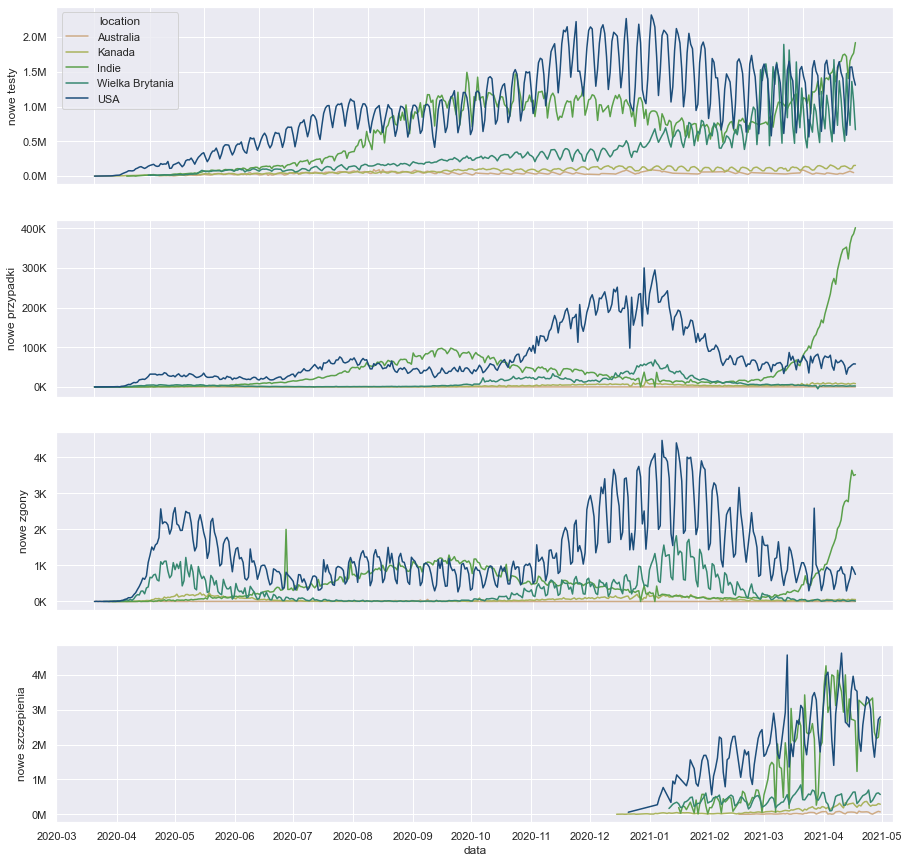

In [413]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 15))
sns.lineplot(x='date', y='new_tests', hue='location', data=covid_df, ax=ax1, palette='gist_earth_r')
sns.lineplot(x='date', y='new_cases', hue='location', data=covid_df, ax=ax2, palette='gist_earth_r')
sns.lineplot(x='date', y='new_deaths', hue='location', data=covid_df, ax=ax3, palette='gist_earth_r')
sns.lineplot(x='date', y='new_vaccinations', hue='location', data=covid_df, ax=ax4, palette='gist_earth_r')

ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

ax1.set(xticklabels=[])
ax1.set(xlabel=None)
ax2.set(xticklabels=[])
ax2.set(xlabel=None)
ax3.set(xticklabels=[])
ax3.set(xlabel=None)
ax4.set(xlabel='data')

ax1.set(ylabel='nowe testy')
ax2.set(ylabel='nowe przypadki')
ax3.set(ylabel='nowe zgony')
ax4.set(ylabel='nowe szczepienia')

ylabels = ['{:.1f}'.format(x) + 'M' for x in ax1.get_yticks()/1000000]
ax1.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax3.get_yticks()/1000]
ax3.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'M' for x in ax4.get_yticks()/1000000]
ax4.set_yticklabels(ylabels)

ax1.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax2.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax3.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax4.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
ax4.set_xticklabels(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
fig.show()

<ipython-input-413-d76e7c5cfc62>:25: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:27: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:29: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:31: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-413-d76e7c5cfc62>:38: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



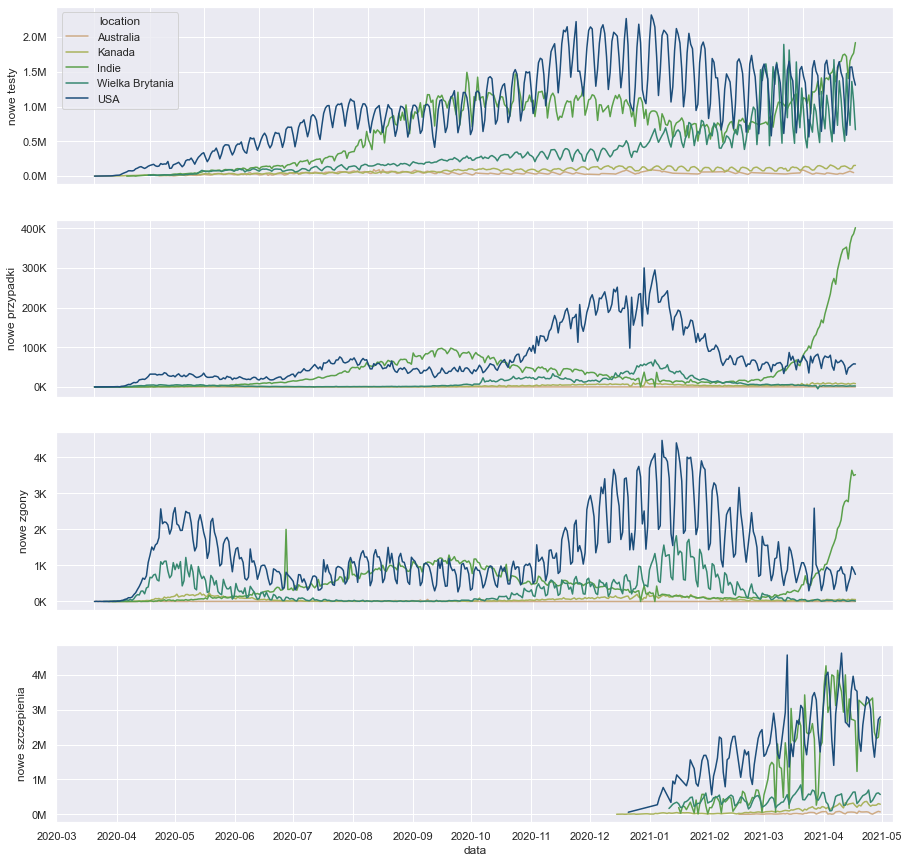

In [413]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 15))
sns.lineplot(x='date', y='new_tests', hue='location', data=covid_df, ax=ax1, palette='gist_earth_r')
sns.lineplot(x='date', y='new_cases', hue='location', data=covid_df, ax=ax2, palette='gist_earth_r')
sns.lineplot(x='date', y='new_deaths', hue='location', data=covid_df, ax=ax3, palette='gist_earth_r')
sns.lineplot(x='date', y='new_vaccinations', hue='location', data=covid_df, ax=ax4, palette='gist_earth_r')

ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

ax1.set(xticklabels=[])
ax1.set(xlabel=None)
ax2.set(xticklabels=[])
ax2.set(xlabel=None)
ax3.set(xticklabels=[])
ax3.set(xlabel=None)
ax4.set(xlabel='data')

ax1.set(ylabel='nowe testy')
ax2.set(ylabel='nowe przypadki')
ax3.set(ylabel='nowe zgony')
ax4.set(ylabel='nowe szczepienia')

ylabels = ['{:.1f}'.format(x) + 'M' for x in ax1.get_yticks()/1000000]
ax1.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'K' for x in ax3.get_yticks()/1000]
ax3.set_yticklabels(ylabels)
ylabels = ['{:.0f}'.format(x) + 'M' for x in ax4.get_yticks()/1000000]
ax4.set_yticklabels(ylabels)

ax1.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax2.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax3.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04'])
ax4.set_xticks(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
ax4.set_xticklabels(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05'])
fig.show()

In [410]:
fig = px.line(covid_df, x="date", y="new_vaccinations", color='location', title="Reported data in time")
fig.show()

### 4. Basic EDA and text prep


Date frequency

In [326]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   text          5000 non-null   object
 2   datetime      5000 non-null   object
 3   no_replies    5000 non-null   int64 
 4   no_retweets   5000 non-null   int64 
 5   no_likes      5000 non-null   int64 
 6   user          5000 non-null   object
 7   location      3767 non-null   object
 8   no_followers  5000 non-null   int64 
 9   sentiment     5000 non-null   object
 10  location_new  5000 non-null   object
dtypes: int64(5), object(6)
memory usage: 429.8+ KB


In [327]:
tweets_df['datetime'] = pd.to_datetime(tweets_df['datetime'])
tweets_df['date'] = tweets_df['datetime'].dt.strftime('%Y-%m')
tweets_df

id                                               text  \
0     1356028686701477888  covid still exists and yall are so so close to...   
1     1293697993875623936  School districts plan for the most UNFEASABLE ...   
2     1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3     1378858911747411968  From the archives: Coming together when we’re ...   
4     1237528569640698112  YO Korean government has succeeded in developi...   
...                   ...                                                ...   
4995  1370524277963943936  #BC #COVID19 Update: In a written statement,th...   
4996  1357841069786948096  PERUVIAN COURT RULING BILL GATES AND OTHER BIL...   
4997  1281376610684269056  Judge temporarily blocks Kentucky governor's C...   
4998  1321963880525038080  South Dakota sets daily record with 19 deaths ...   
4999  1361100915248410880  President Joe Biden will hold his first event ...   

                      datetime  no_replies  no_retweets  no_likes  \
0    2021-01-31 23:56:47+00:00           0            0         0   
1    2020-08-12 23:56:52+00:00           0            0         0   
2    2020-04-22 23:58:34+00:00           0            0         0   
3    2021-04-04 23:55:57+00:00           0            0         1   
4    2020-03-10 23:59:37+00:00           1            5         3   
...                        ...         ...          ...       ...   
4995 2021-03-12 23:57:05+00:00           1            1         1   
4996 2021-02-05 23:58:33+00:00           1            0         0   
4997 2020-07-09 23:56:05+00:00           0            0         0   
4998 2020-10-29 23:55:24+00:00           1            0         0   
4999 2021-02-14 23:52:00+00:00           0            0         0   

                                                 user  \
0                                              diji 🎀   
1                  @Pechilvr @WarOnFibro #OwnYourData   
2                                        Sean Mulcahy   
3                                Mum Muddling Through   
4                                         miracassano   
...                                               ...   
4995                                     Melanie Nagy   
4996                                   Brayden Carter   
4997  Independent Underground Network 🌸 #FreeFromFear   
4998                                          InForum   
4999                                     TaiwanStrong   

                       location  no_followers sentiment     location_new  \
0                     Mark Tuan            43  negative         Nieznana   
1                North Carolina           935   neutral              USA   
2     Ballarat North, Australia          1828   neutral        Australia   
3                 Kent, England         14712  positive  Wielka Brytania   
4                           NaN          1231  positive         Nieznana   
...                         ...           ...       ...              ...   
4995                        NaN          5759  positive         Nieznana   
4996                        NaN           581  positive         Nieznana   
4997               Where We Are          6032  negative         Nieznana   
4998                Fargo, N.D.         40158   neutral         Nieznana   
4999                        NaN           594   neutral         Nieznana   

         date  
0     2021-01  
1     2020-08  
2     2020-04  
3     2021-04  
4     2020-03  
...       ...  
4995  2021-03  
4996  2021-02  
4997  2020-07  
4998  2020-10  
4999  2021-02  

[5000 rows x 12 columns]

C:\Users\Magda\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\Users\Magda\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 720x360 with 0 Axes>

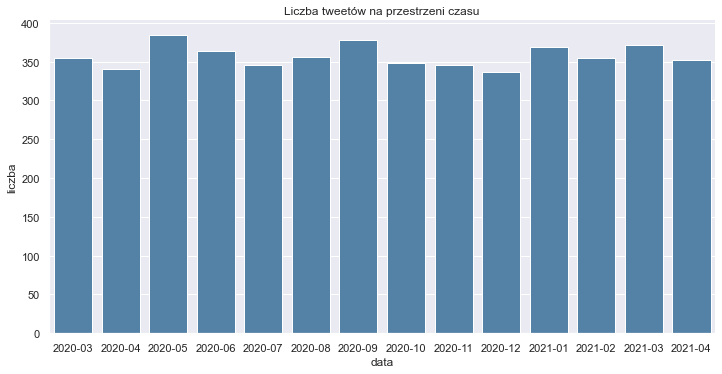

In [328]:


# date_df = tweets_df.groupby(tweets_df["datetime"].dt.week).count()['id'].reset_index()

plt.figure(figsize=(10,5))
fig = sns.factorplot("date", data=tweets_df.sort_values('date'), aspect=2,
                       kind="count", color='steelblue')
fig.set(xlabel='data', ylabel='liczba', title='Liczba tweetów na przestrzeni czasu')
plt.show()

Location - work in progress:

- 106,091 missing user locations
- usually a combination of countries, cities, weird characters or vague mentions 

In [331]:
# df_loc.to_csv('df.csv')

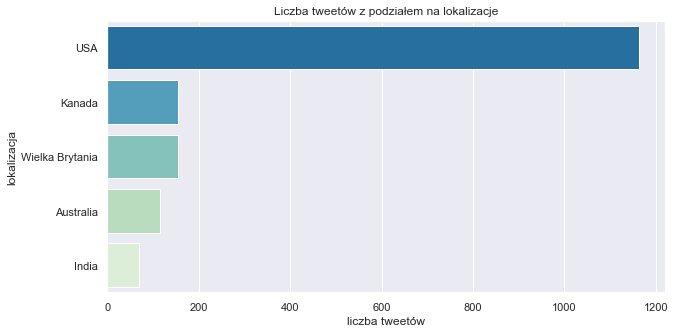

In [336]:
# location
plt.figure(figsize=(10,5))
fig = sns.countplot(y="location_new", data=tweets_df, order=tweets_df.loc[tweets_df['location_new'] != 'Nieznana'].location_new.value_counts().iloc[:5].index, palette='GnBu_r')
fig.set(xlabel='liczba tweetów', ylabel='lokalizacja', title='Liczba tweetów z podziałem na lokalizacje')
plt.show()

Principle summaries - work in progress

In [17]:
# number of followers retweets replies and likes

# tweets_df_stats = pd.melt(tweets_df, id_vars='id', value_vars=['no_followers', 'no_retweets', 'no_replies', 'no_likes'], var_name='type', value_name='value')

# fig = px.histogram(tweets_df_stats, 
#                     x="value", 
#                     color="type", 
#                     marginal="rug", # box violin
#                     hover_data=tweets_df_stats.columns)
# fig.show()

Correlations

<AxesSubplot:>

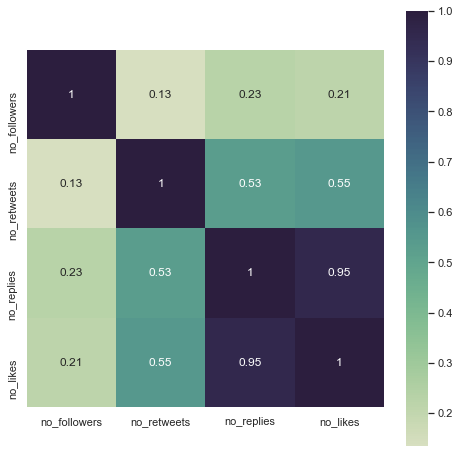

In [108]:
columns_show=['no_followers', 'no_retweets', 'no_replies', 'no_likes']
f, ax = plt.subplots(figsize=(8, 8))
corr = tweets_df[columns_show].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), square=True, ax=ax,annot=True)

#### Text pre-processing

In [19]:
# List of punctations to be removed (# and @ might be reconsidered)
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
# Setting up stopwords list
stopwords = set(STOPWORDS)
# excluding keywords used in query (collection words)
stopwords.update(['covid', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccinated', 'vaccination', 'lockdown', 'quarantine'])
# excluding a couple more irrelevant ones
stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're', 'amp'])

In [21]:
df = tweets_df[['text']]
df.head()

text
0  covid still exists and yall are so so close to...
1  School districts plan for the most UNFEASABLE ...
2  COVID-19 Omnibus (Emergency Measures) Bill 202...
3  From the archives: Coming together when we’re ...
4  YO Korean government has succeeded in developi...

#### Emojis and emoticons

In [22]:
# Function for converting emoticons into word
# def convert_emoticons(text):
#     for emot in EMOTICONS:
#         text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
#     return text

# tweets_df['emojis'] = tweets_df['text'].apply(lambda x: extract_emojis(x))
df['text_emoji'] = df['text'].apply(lambda x: emojis.decode(x))
# df['text_clean'] = df['text'].apply(lambda x: convert_emoticons(x))
df.head()

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   

                                          text_emoji  
0  covid still exists and yall are so so close to...  
1  School districts plan for the most UNFEASABLE ...  
2  COVID-19 Omnibus (Emergency Measures) Bill 202...  
3  From the archives: Coming together when we’re ...  
4  YO Korean government has succeeded in developi...

In [23]:
df['text'][0]

'covid still exists and yall are so so close to mark 😤😤😤😤😤😤😤'

In [24]:
df['text_emoji'][0]

'covid still exists and yall are so so close to mark :triumph::triumph::triumph::triumph::triumph::triumph::triumph:'

In [25]:
# Cleaning functions - 1st stage
def clean_text(text):
    # lowercase
    text_new = text.lower()
    
    # remove key-words
    key_words = ['covid', 'covid-19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccines', 'vaccinated', 'vaccination', 'lockdown', 'quarantine', 'sars-cov-2']
    text_new  = ' '.join([word for word in text_new.split() if word not in key_words])
    
    # remove URL part
    text_new = text_new.replace("#", " #") # to keep hashtags occuring right after url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_new = url_pattern.sub(r'', text_new)

    # remove new line sign 
    text_new = text_new.replace("\n", " ")
    text_new = " ".join(text_new.split())

    # remove punctation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 
    text_new = text_new.translate(translator)
    text_new = re.sub('[0-9]+', '', text_new)

    return text_new

In [26]:
df['text_clean'] = df['text_emoji'].apply(lambda x: clean_text(x))
df.head(10)

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_emoji  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_clean  
0  still exists and yall are so so close to mark ...  
1  school districts plan for the most unfeasable ...  
2  omnibus  emergency measures  bill  introduced ...  
3  from the archives  coming together when we’re ...  
4  yo korean government has succeeded in developi...  
5  this is exactly the difference that every amer...  
6  cold plasma inactivates  medrxivpreprint  ucla...  
7  update  care packages for the ucsd th floor  n...  
8  i get they want to play  people want to watch ...  
9  my yr old s first test came back negative toda...

In [27]:
# Cleaning functions - 2nd stage
# Tokenization, stopwords, stemming or lemmatization 
def stem_lem_split(text, method='stem'):
    # tokenization
    tokens = re.split('\W+', text)

    # remove stopwords 
    text_s = [word for word in tokens if word not in stopwords]
    
    if method=='stem':
        # stemming
        ps = nltk.PorterStemmer()
        text_stem = [ps.stem(word) for word in text_s] 
        return text_stem

    elif method=='lem':
        # lemmatization
        wn = nltk.WordNetLemmatizer()
        text_lem = [wn.lemmatize(word) for word in text_s]
        return text_lem
    else:
        print('Invalid method')

In [28]:
df['text_stem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='stem'))
df['text_lem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='lem'))
df.head(10)

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_emoji  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_clean  \
0  still exists and yall are so so close to mark ...   
1  school districts plan for the most unfeasable ...   
2  omnibus  emergency measures  bill  introduced ...   
3  from the archives  coming together when we’re ...   
4  yo korean government has succeeded in developi...   
5  this is exactly the difference that every amer...   
6  cold plasma inactivates  medrxivpreprint  ucla...   
7  update  care packages for the ucsd th floor  n...   
8  i get they want to play  people want to watch ...   
9  my yr old s first test came back negative toda...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   
5  [exactli, differ, everi, american, think, vote...   
6  [cold, plasma, inactiv, medrxivpreprint, ucla,...   
7  [updat, care, packag, ucsd, th, floor, nurs, i...   
8  [want, play, peopl, want, watch, sport, done, ...   
9  [yr, old, first, test, came, back, neg, today,...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...  
5  [exactly, difference, every, american, think, ...  
6  [cold, plasma, inactivates, medrxivpreprint, u...  
7  [update, care, package, ucsd, th, floor, nurse...  
8  [want, play, people, want, watch, sport, done,...  
9  [yr, old, first, test, came, back, negative, t...

#### Word Clouds


In [29]:
string_wc = pd.Series(df['text_clean']).str.cat(sep=' ')

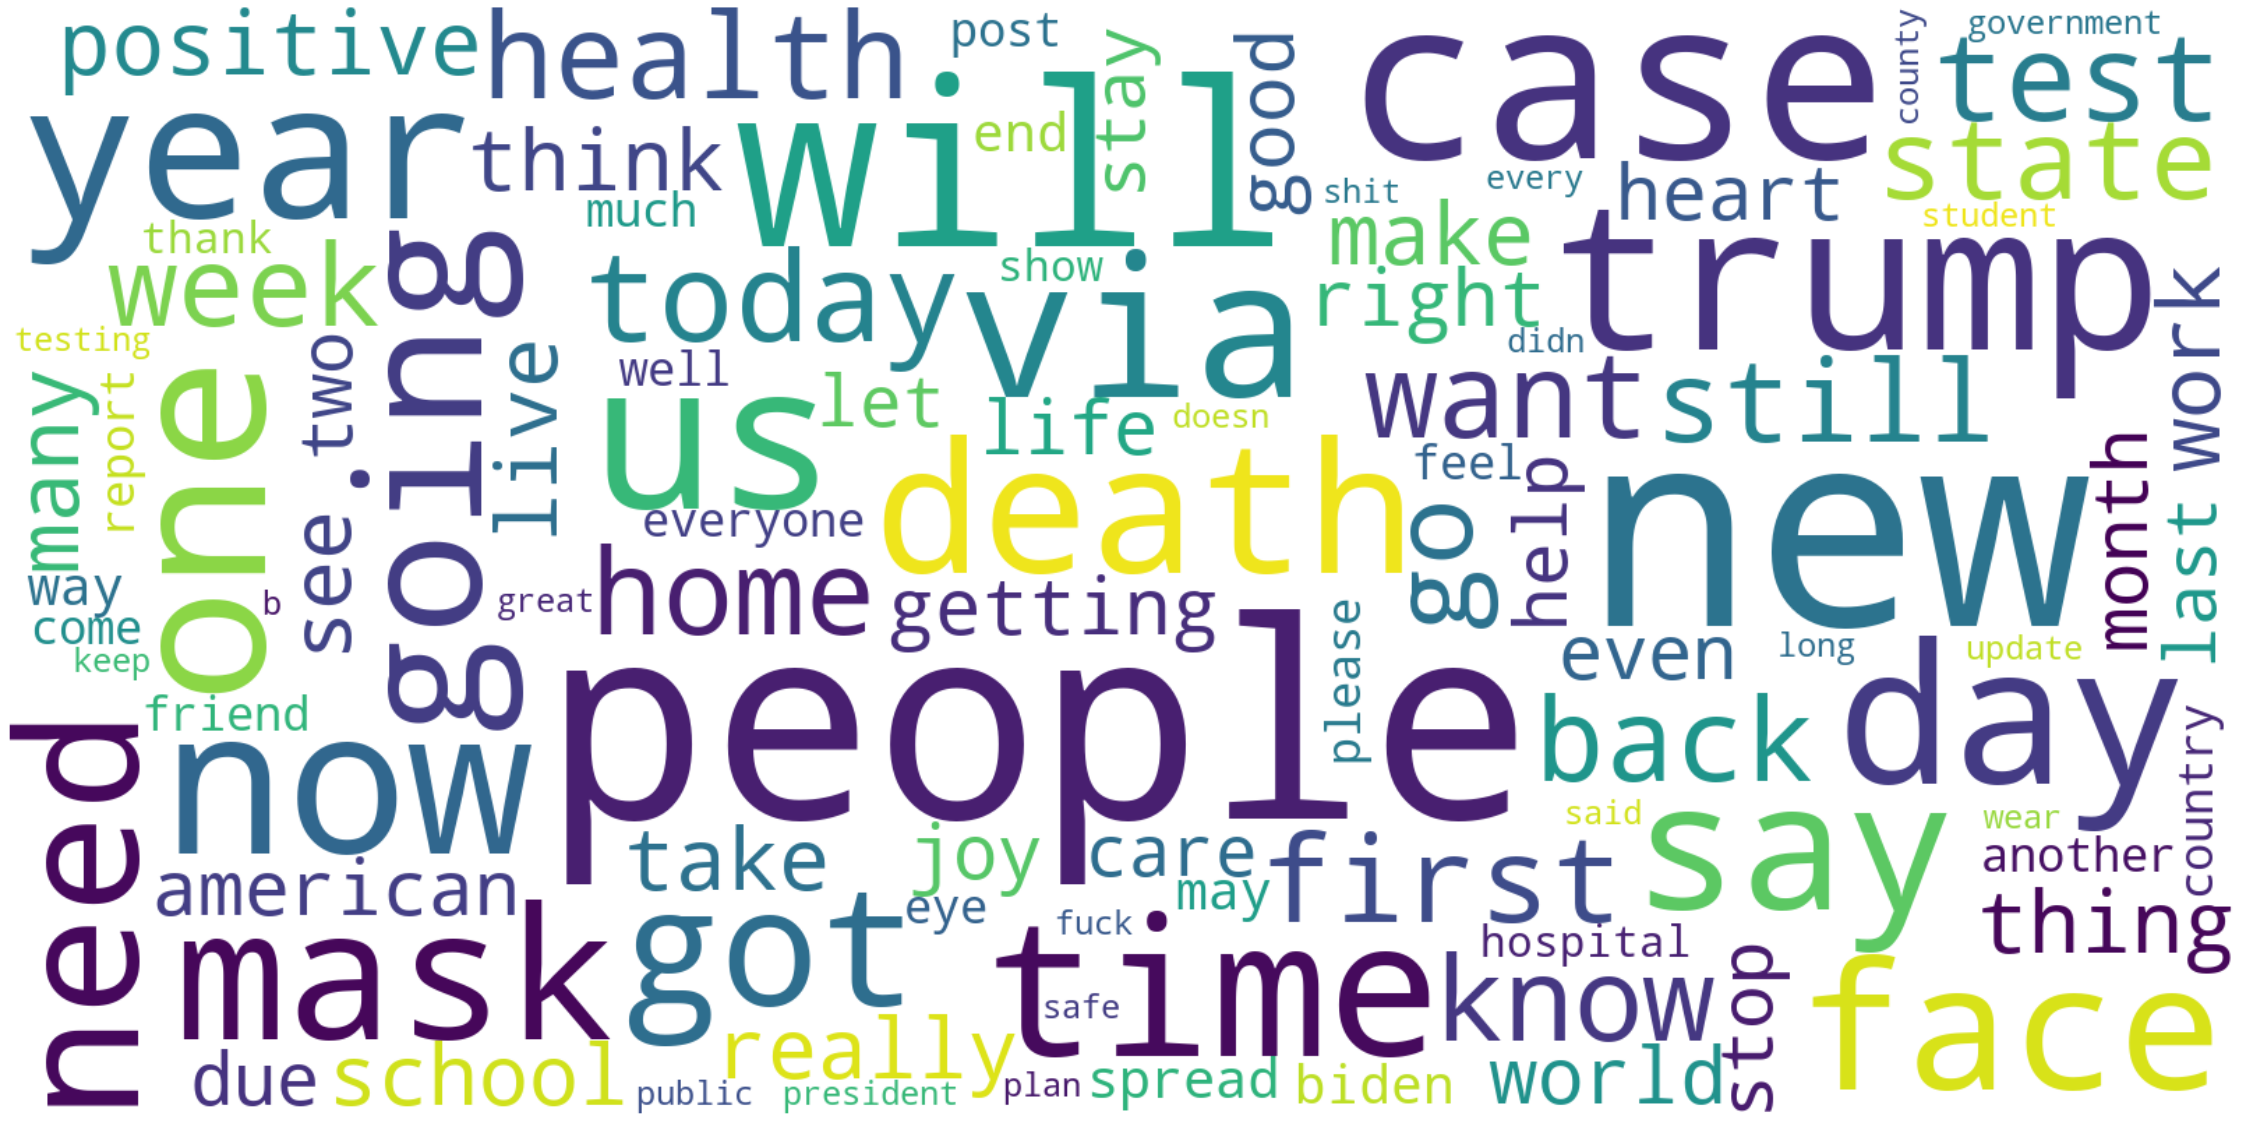

In [30]:
# Word Cloud before stemming/lemmatization
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_wc)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

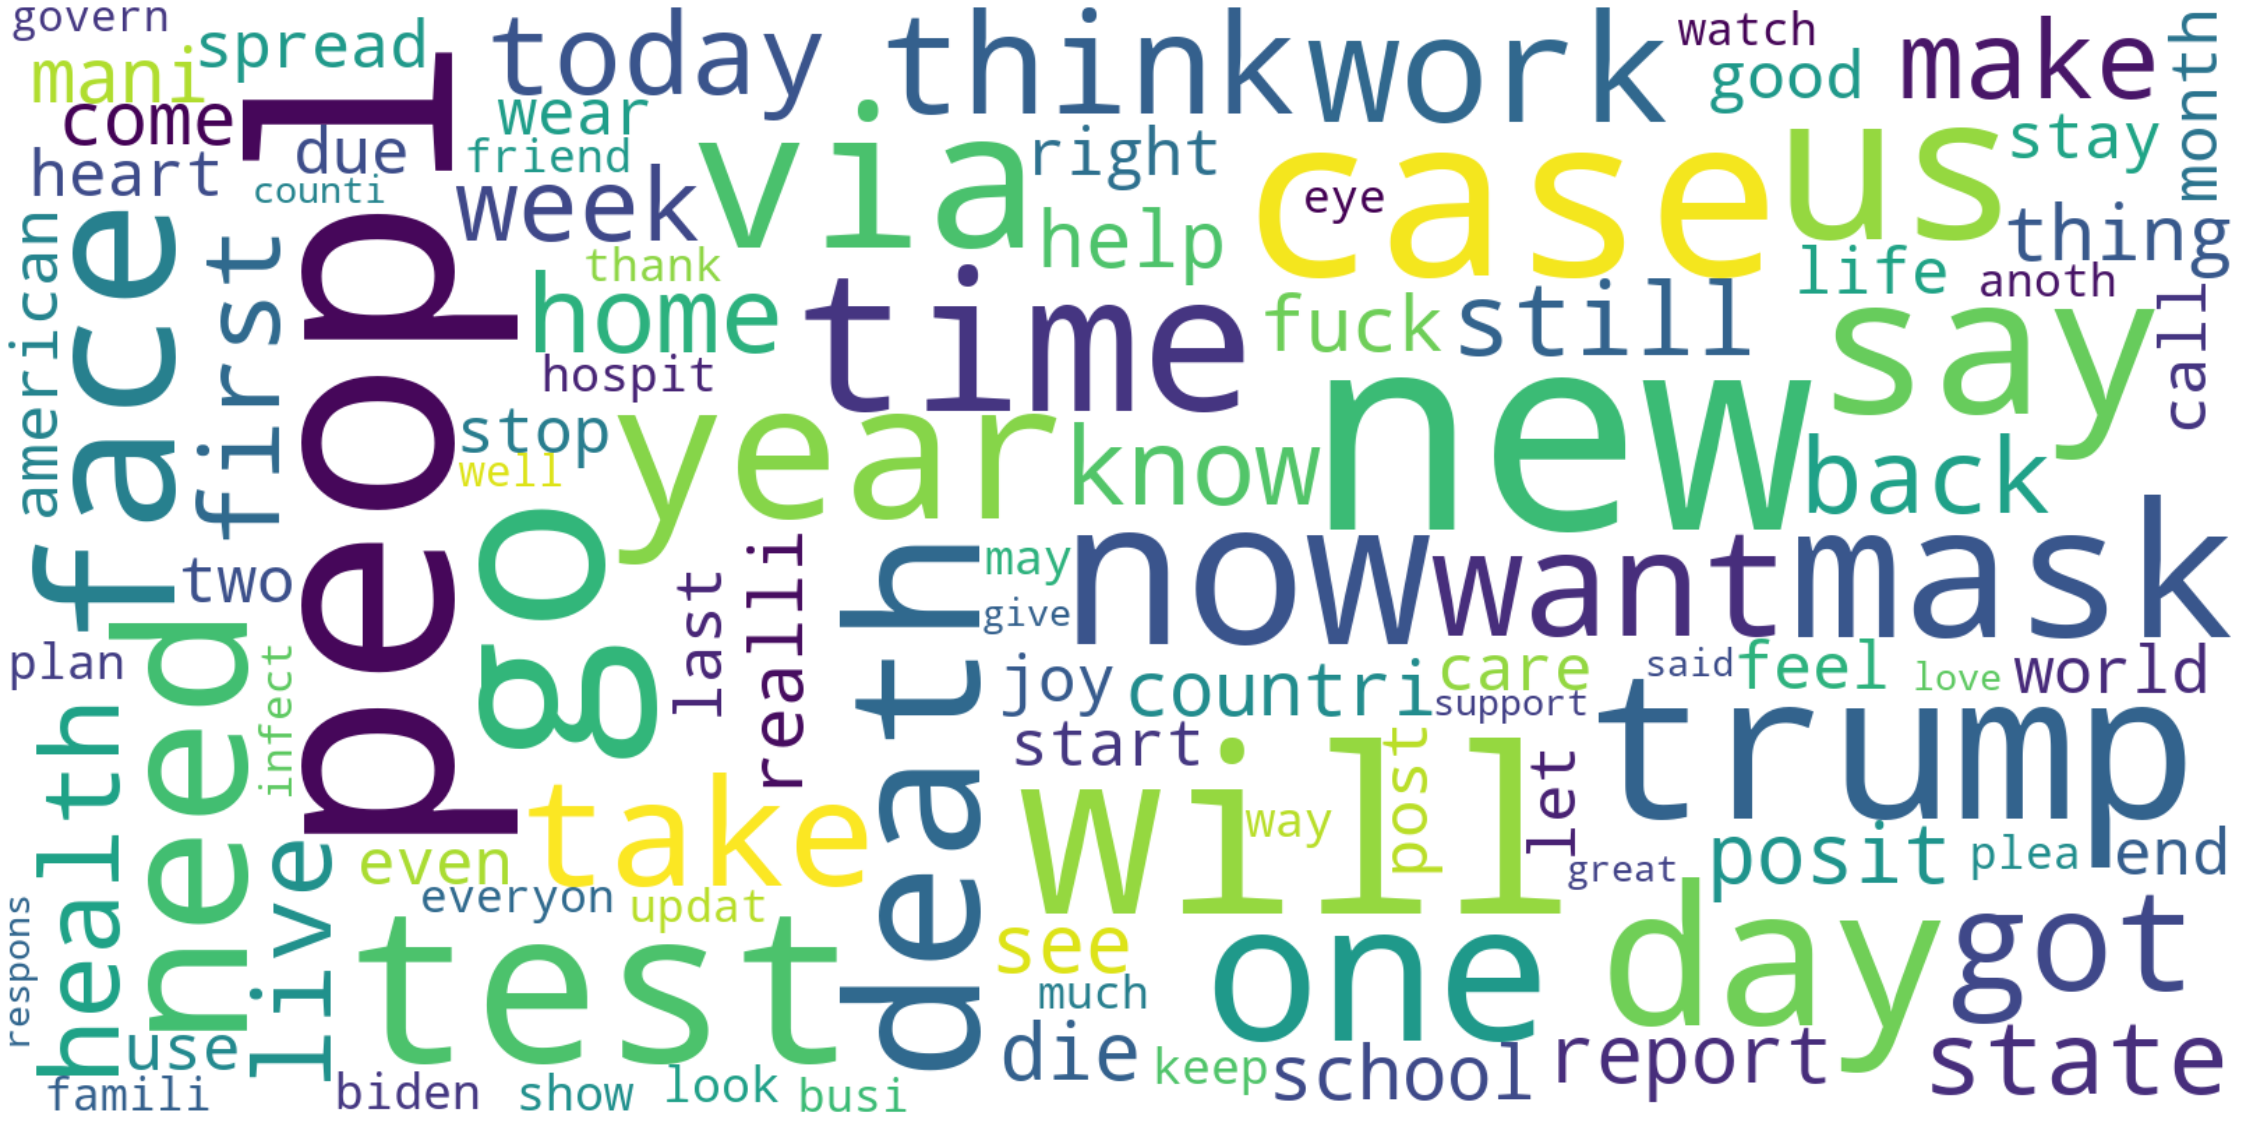

In [31]:
# Word Cloud after stemming
string_stem = df['text_stem'].apply(lambda x: " ".join(x))
string_stem = pd.Series(string_stem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_stem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

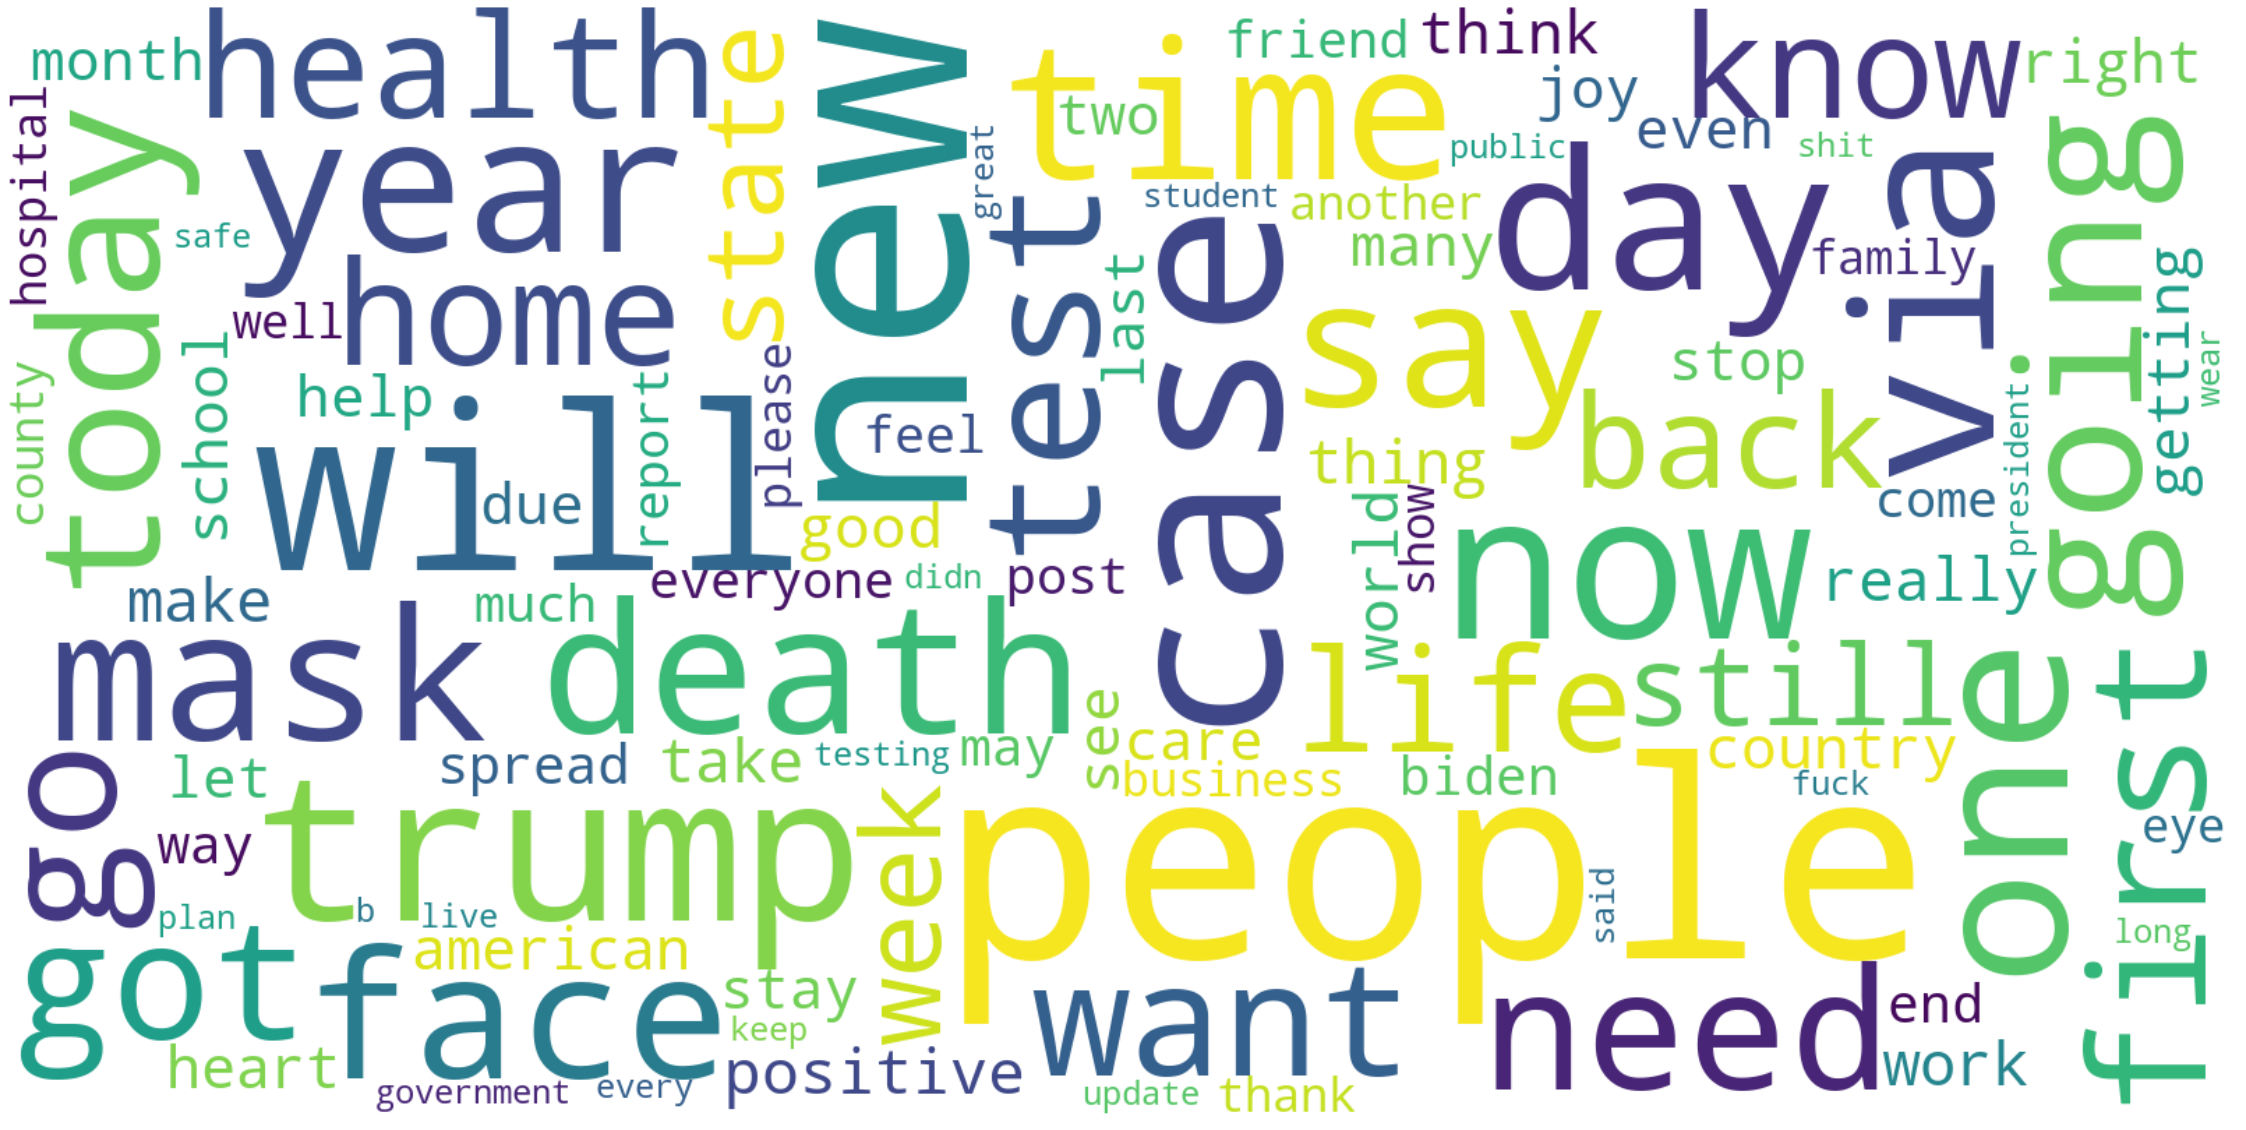

In [32]:
# Word Cloud after lemmatization
string_lem = df['text_lem'].apply(lambda x: " ".join(x))
string_lem = pd.Series(string_lem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_lem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Bigrams and Trigrams

In [239]:
def create_ngram(tweets, n=2):
    if n==2:
        terms = [list(bigrams(tweet)) for tweet in tweets]
        colname = 'bigram'
    elif n==3:
        terms = [list(everygrams(tweet, 3, 3)) for tweet in tweets]
        colname = 'trigram'
    else: 
        print("Invalid n")
        return 0

    # Flatten list of bigrams in clean tweets
    ngrams = list(itertools.chain(*terms))
    # Create counter of words in clean bigrams
    ngram_counts = collections.Counter(ngrams)
    # DataFrame from the counter
    ngram_df = pd.DataFrame(ngram_counts.most_common(50),columns=[colname, 'count'])
    return ngram_df

In [240]:
bigram_df = create_ngram(df['text_stem'], n=2)
trigram_df = create_ngram(df['text_stem'], n=3)

In [241]:
bigram_df = bigram_df.drop([bigram_df.index[4], bigram_df.index[8], bigram_df.index[9], bigram_df.index[14], bigram_df.index[21], bigram_df.index[20], bigram_df.index[19], \
    bigram_df.index[38], bigram_df.index[42]])
bigram_df_wide = bigram_df.copy()
bigram_df = bigram_df.iloc[:25,:]
bigram_df['bigram'] = bigram_df['bigram'].astype(str)
bigram_df['bigram'] = bigram_df['bigram'].str.replace("(", "")
bigram_df['bigram'] = bigram_df['bigram'].str.replace(")", "")
bigram_df['bigram'] = bigram_df['bigram'].str.replace("'", "")
bigram_df

<ipython-input-241-7911e5094444>:6: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.

<ipython-input-241-7911e5094444>:7: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



bigram  count
0         new, case     82
1       test, posit     80
2        wear, mask     74
3       via, youtub     38
5   social, distanc     32
6        peopl, die     32
7        stay, home     31
10       right, now     29
11       face, mask     27
12        new, york     24
13         go, back     23
15      first, time     21
16      plead, face     21
17      white, hous     21
18   public, health     20
22       last, week     18
23       nurs, home     18
24       joe, biden     18
25       last, year     18
26        year, old     17
27      unit, state     17
28      case, death     17
29   health, offici     17
30         go, away     17
31      death, toll     16

In [253]:
trigram_df.iloc[16, 1] = 13
trigram_df = trigram_df.sort_values('count', ascending=False).reset_index(drop=True)
trigram_df = trigram_df.drop([trigram_df.index[0], trigram_df.index[3], trigram_df.index[4], trigram_df.index[5],  trigram_df.index[6],  trigram_df.index[7],  trigram_df.index[9],\
      trigram_df.index[12],  trigram_df.index[13],  trigram_df.index[14],  trigram_df.index[15],  trigram_df.index[17],  trigram_df.index[20],  trigram_df.index[27],  trigram_df.index[28],\
      trigram_df.index[39]]).iloc[:25,:]
trigram_df['trigram'] = trigram_df['trigram'].astype(str)
trigram_df['trigram'] = trigram_df['trigram'].str.replace("(", "")
trigram_df['trigram'] = trigram_df['trigram'].str.replace(")", "")
trigram_df['trigram'] = trigram_df['trigram'].str.replace("'", "")
# trigram_df

<ipython-input-253-260dbefb7ed1>:7: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.

<ipython-input-253-260dbefb7ed1>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



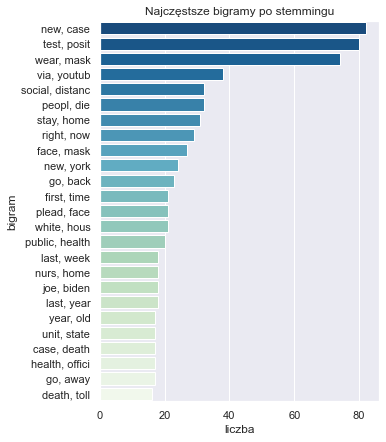

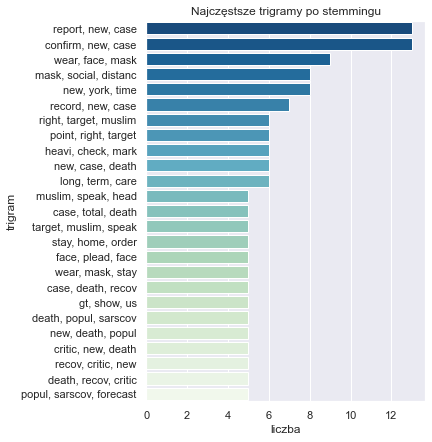

In [254]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plt.figure(figsize=(5,7))
fig = sns.barplot(x=bigram_df['count'], y=bigram_df['bigram'], palette='GnBu_r')
fig.set(xlabel='liczba', ylabel='bigram', title='Najczęstsze bigramy po stemmingu')
plt.show()

plt.figure(figsize=(5,7))
fig = sns.barplot(x=trigram_df['count'], y=trigram_df['trigram'], palette='GnBu_r')
fig.set(xlabel='liczba', ylabel='trigram', title='Najczęstsze trigramy po stemmingu')
plt.show()

#### Text Networks - work in progress

Stemmed text

In [244]:
# Create dictionary of bigrams and their counts
d = bigram_df_wide.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

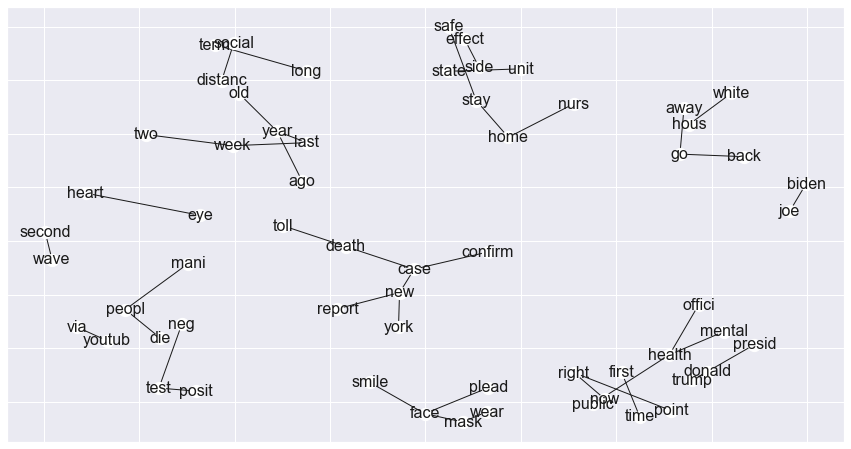

In [271]:
import math
fig, ax = plt.subplots(figsize=(15,8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 with_labels = True,
                 ax=ax,
                 node_color='white',
                 node_size=150)

# fig.set(title='Siatka słów - bigramy po stemmingu') 
# Create offset labels
# for key, value in pos.items():
#     x, y = value[0]+.135, value[1]+.045
#     ax.text(x, y,
#             s=key,
#             bbox=dict(alpha=0.1),
#             horizontalalignment='center', fontsize=12)
   
plt.show()

### 5. Saving the output file

In [ ]:
# Adding cleaned text to initial twitter df
tweets_df['text_clean'] = df['text_clean']
tweets_df['text_stem'] = df['text_stem']
tweets_df['text_lem'] = df['text_lem']
tweets_df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment                                         text_clean  \
0            43  negative  still exists and yall are so so close to mark ...   
1           935   neutral  school districts plan for the most unfeasable ...   
2          1828   neutral  omnibus  emergency measures  bill  introduced ...   
3         14712  positive  from the archives  coming together when we’re ...   
4          1231  positive  yo korean government has succeeded in developi...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...

In [ ]:
tweets_df.to_pickle('../data/covid19_tweets_cleaned_5000.pkl')

In [ ]:
# tweets_df.to_csv('../data/covid19_tweets_cleaned.csv', index=False)